# Solution: Amoeba Detection

This is the solution for the assignment of amoeba detection. 

We will introduce chemistry students to object detection with machine learning. We train our custom model with the images collected by ourselves in chemistry or biology lab. 



## Table of content


* Set up environment
* Load images dataset
* Data preparation and configurations
* Train custom amoeba model
* Evaluate amoeba model
* Inference

# Set up environment

We will install Mask R-CNN repo from Github (https://github.com/matterport/Mask_RCNN) and necessary packages. We need to make sure the packages we are using is the correct version.

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.1.6
!pip install h5py==2.10.0
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 503 kB 68.4 MB/s 
     |████████████████████████████████| 3.8 MB 54.7 MB/s 
     |████████████████████████████████| 50 kB 9.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c046cb6a7236a00cf23efed49d1c01345b7fb437c67d2d27518c298eee5d1262
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdis

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


# Load images dataset

We will clone the project from our github (https://github.com/BaosenZ/amoeba-detection.git). The dataset is included inside the github project.

In [ ]:
# download dataset from github

%%shell
git clone https://github.com/BaosenZ/amoeba-detection.git


Cloning into 'amoeba-detection'...
remote: Enumerating objects: 2453, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 2453 (delta 178), reused 376 (delta 177), pack-reused 2075
Receiving objects: 100% (2453/2453), 354.59 MiB | 33.44 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (3425/3425), done.


In [ ]:
# copy the dataset from github folder to 'content' 
!cp -r '/content/amoeba-detection/dataset-section2/amoebaDataset/trainingDataset' '/content'
!cp -r '/content/amoeba-detection/dataset-section2/amoebaDataset/testDataset' '/content'

In [ ]:
# upload zip of the dataset from local

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# !unzip trainingDataset.zip
# !unzip testDataset.zip

# Data preparation and configurations

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class AmoebaDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		# Add classes
		self.add_class("dataset", 1, "amoeba")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			# based on images number, split the training and validation data
			if is_train and int(image_id) >= 170:
				continue
			if not is_train and int(image_id) < 170:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('amoeba'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


# prepare train set
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare val set
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))


Train: 169
Val: 27


Config files allow you to separate the code from the parameters of the machine learning pipeline to help produce repeatable outcomes.

In [ ]:
# prepare config
class AmoebaConfig(Config):
	# Give the configuration a recognizable name
	NAME = "amoeba_cfg"
	# Number of classes (including background)
	NUM_CLASSES = 1 + 1 # background + 1 amoeba
	# Use a small epoch since the data is simple
	STEPS_PER_EPOCH = 131
	DETECTION_NMS_THRESHOLD = 0.5

config = AmoebaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Train custom amoeba model

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. More information about Tensorboard is available here (https://www.tensorflow.org/tensorboard/get_started).

In [ ]:
# run tensorboard to visualize training
import keras
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

./my_logs/run_2022_06_20-22_07_58


The Mask R-CNN structure is described in the paper(He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).) and also in my ppt.

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# train the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, val_set, learning_rate=0.002, epochs=10, layers='heads', custom_callbacks=[tensorboard_cb])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.002

Checkpoint Path: ./amoeba_cfg20220620T2208/mask_rcnn_amoeba_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
130/131 [============================>.] - ETA: 1s - loss: 0.8721 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.3379

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 215s 2s/step - loss: 0.8721 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.3228 - mrcnn_mask_loss: 0.3387 - val_loss: 0.7182 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.1747 - val_mrcnn_class_loss: 0.0286 - val_mrcnn_bbox_loss: 0.2218 - val_mrcnn_mask_loss: 0.2899

Epoch 2/10
131/131 [==============================] - 171s 1s/step - loss: 0.5120 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2258 - val_loss: 0.6222 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.1797 - val_mrcnn_class_loss: 0.0219 - val_mrcnn_bbox_loss: 0.1731 - val_mrcnn_mask_loss: 0.2441
Epoch 3/10
131/131 [==============================] - 173s 1s/step - loss: 0.4560 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2046 - val_loss: 0.6388 - val_rpn_class_loss: 0.003

# Evaluate amoeba model
 


Evaluate the mask rcnn model on the training, validation and test amoeba dataset

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	mAP = mean(APs)
	return mAP


In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# !!!load model weights
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# find last trained weights: 
model_path = model.find_last()
model.load_weights(model_path, by_name=True)

# set a specific path
#model.load_weights('amoeba_cfg20210206T1746/mask_rcnn_amoeba_cfg_0007.h5', by_name=True)  # change the weights path to run the code



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 10


In [ ]:
# load the train dataset
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the val dataset
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))
# load the test dataset
test_set = AmoebaDataset()
test_set.load_dataset('testDataset')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on val dataset
val_mAP = evaluate_model(val_set, model, cfg)
print("Val mAP: %.3f" % val_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train: 169
Val: 27
Test: 20
Train mAP: 0.918
Val mAP: 0.880
Test mAP: 0.883


In [ ]:
# visualize training in Tensorboard

# The tensorboard file name can be found in 'my_logs'. Then change the tensorboard file name.

# %load_ext tensorboard
# %tensorboard --logdir ./my_logs/run_2022_06_20-22_07_58

# Inference


## Drop inference

The concentration of amoebae in a sample can be determined by imaging an entire drop of a particular volume of the sample and counting the number of amoebae present there. The models described above were used to analyze the images of the entire drop and count the number of bounding boxes within all images. 

There are 6 drops examples. Students can change the file location to do inference on each of the drop. 

We will detect the images in testDataset folder by calling model.detect().

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

  
def count1_amoeba(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  
  count=0
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >=0.96:
      count = count +1
  print("The number of amoeba is ", count)
  return count

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >= 0.96:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()


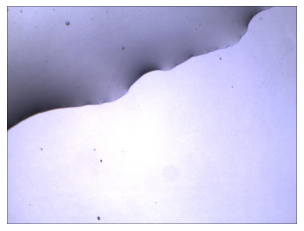

The number of amoeba is  0
0


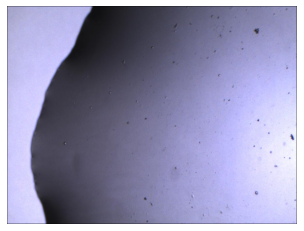

The number of amoeba is  0
0


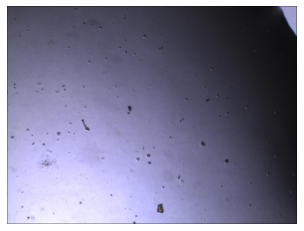

The number of amoeba is  0
0


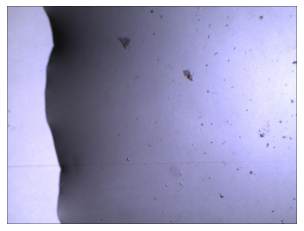

The number of amoeba is  0
0


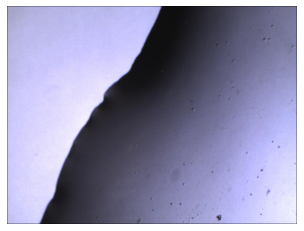

The number of amoeba is  0
0


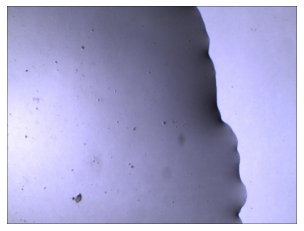

The number of amoeba is  0
0


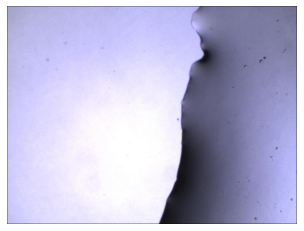

The number of amoeba is  0
0


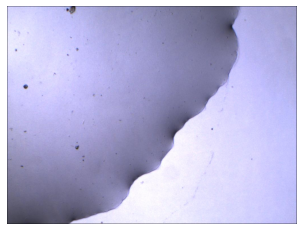

The number of amoeba is  0
0


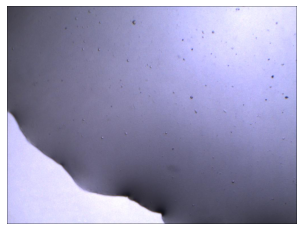

The number of amoeba is  0
0


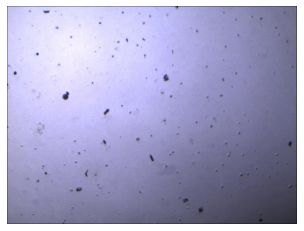

The number of amoeba is  0
0


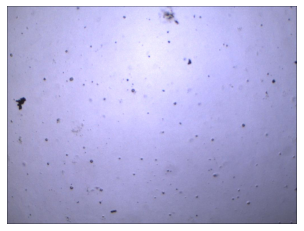

The number of amoeba is  0
0


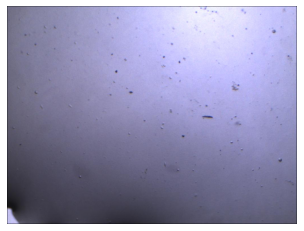

The number of amoeba is  0
0


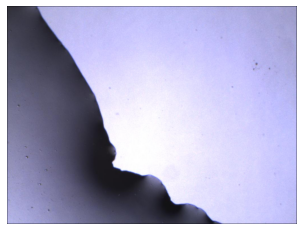

The number of amoeba is  0
0


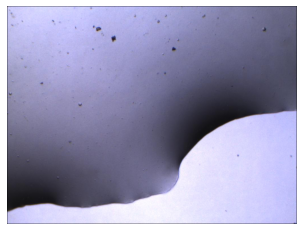

The number of amoeba is  0
0


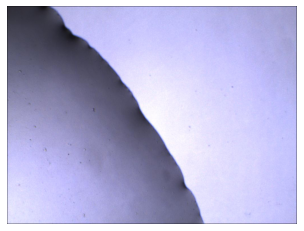

The number of amoeba is  0
0


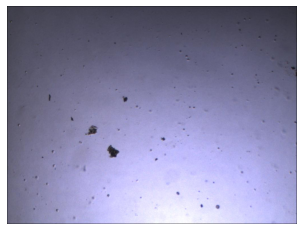

The number of amoeba is  0
0


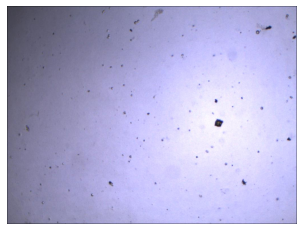

The number of amoeba is  0
0


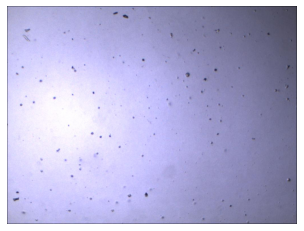

The number of amoeba is  0
0


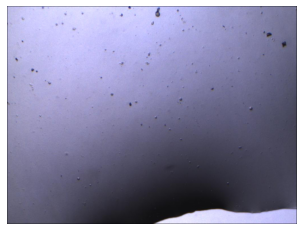

The number of amoeba is  0
0


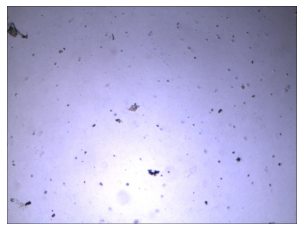

The number of amoeba is  0
0


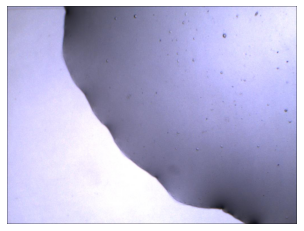

The number of amoeba is  0
0


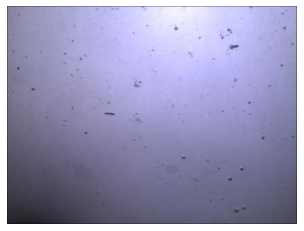

The number of amoeba is  0
0


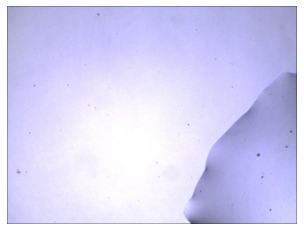

The number of amoeba is  0
0


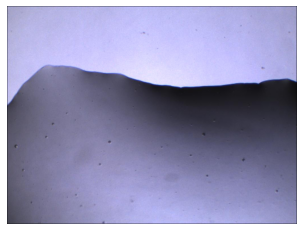

The number of amoeba is  0
0


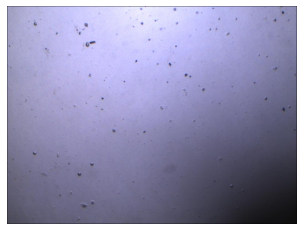

The number of amoeba is  0
0


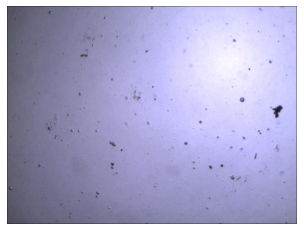

The number of amoeba is  0
0


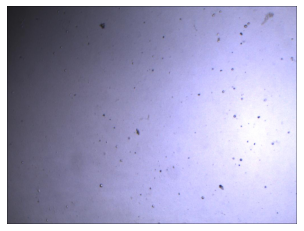

The number of amoeba is  0
0


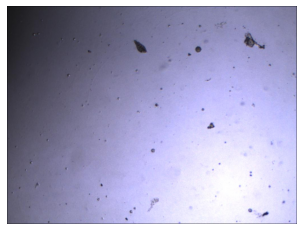

The number of amoeba is  0
0


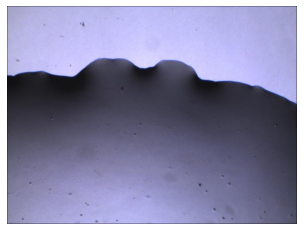

The number of amoeba is  0
0


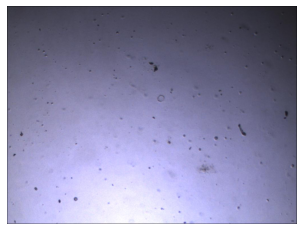

The number of amoeba is  0
0


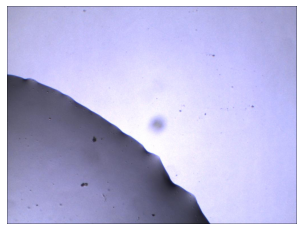

The number of amoeba is  0
0


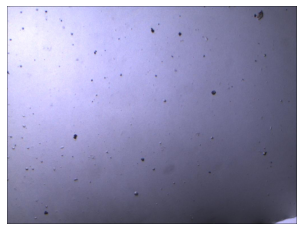

The number of amoeba is  0
0


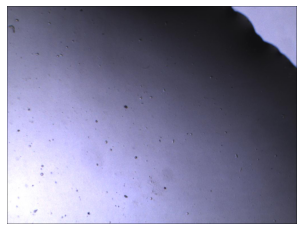

The number of amoeba is  0
0


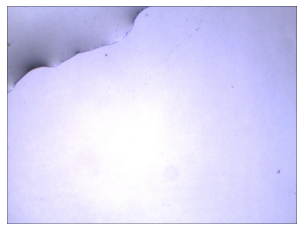

The number of amoeba is  0
0


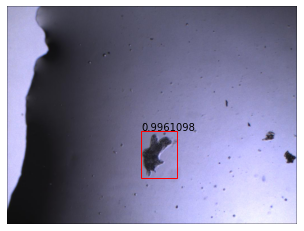

The number of amoeba is  1
1


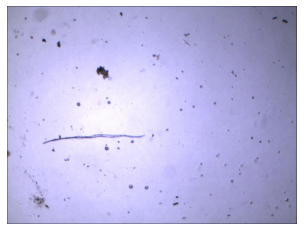

The number of amoeba is  0
1


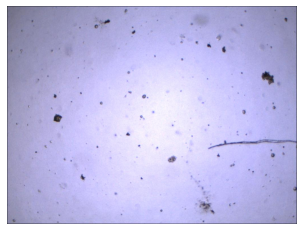

The number of amoeba is  0
1


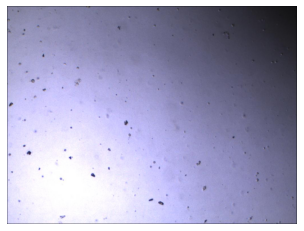

The number of amoeba is  0
1


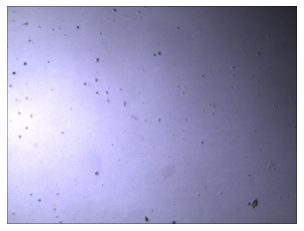

The number of amoeba is  0
1


In [ ]:
# create folder to save inference images
from PIL import Image
if not os.path.exists("drop1-inference"):
  os.mkdir("drop1-inference")

# find the path of original inference images
images_dir = "amoeba-detection/dataset-section2/dropInference/drop1/drop1"
save_root = "drop1-inference/"
# run the inference and count the amoeba
t=0
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  save_file = save_root + img
  save_predicted(image, model, cfg, save_file)
  t=t + count1_amoeba(image,model,cfg)
  print(t)

In [ ]:
# save the inference folder to local

# !zip -r drop1-inference.zip drop1-inference
# from google.colab import files
# files.download("drop1-inference.zip")

## Test dataset inference

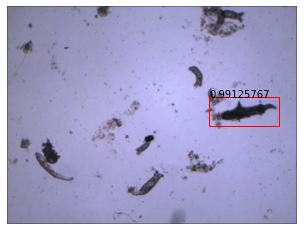

The number of amoeba is  1
1


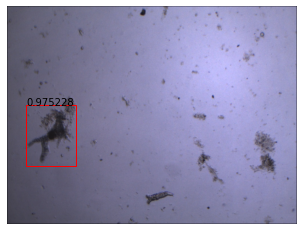

The number of amoeba is  1
2


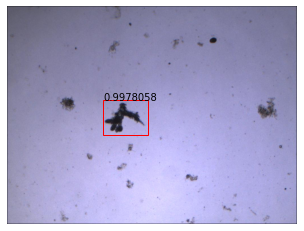

The number of amoeba is  1
3


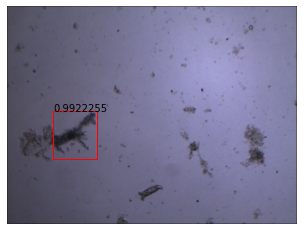

The number of amoeba is  1
4


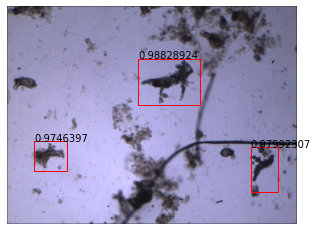

The number of amoeba is  3
7


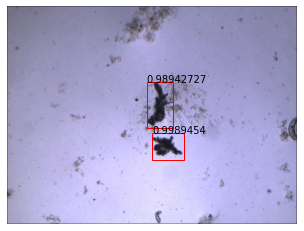

The number of amoeba is  2
9


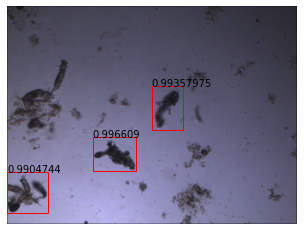

The number of amoeba is  3
12


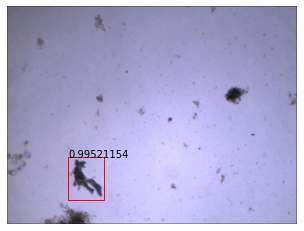

The number of amoeba is  1
13


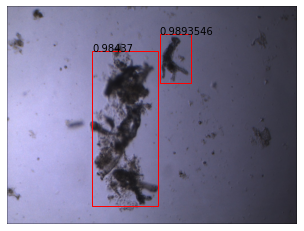

The number of amoeba is  2
15


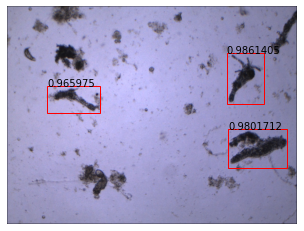

The number of amoeba is  3
18


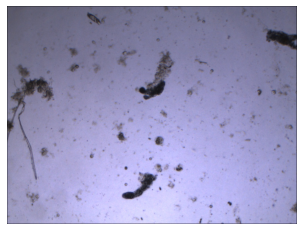

The number of amoeba is  0
18


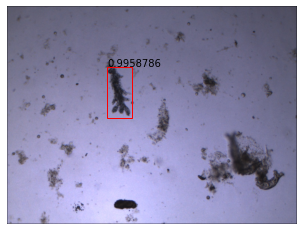

The number of amoeba is  1
19


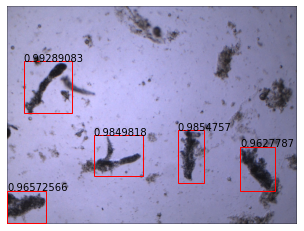

The number of amoeba is  5
24


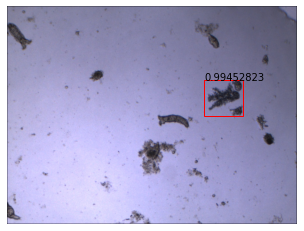

The number of amoeba is  1
25


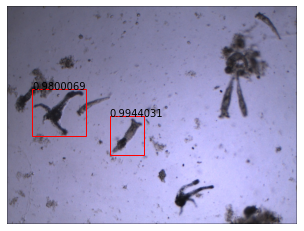

The number of amoeba is  2
27


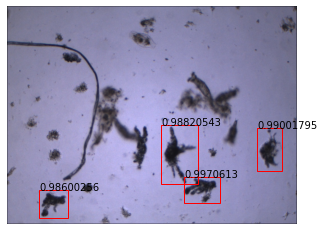

The number of amoeba is  4
31


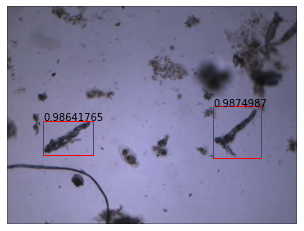

The number of amoeba is  2
33


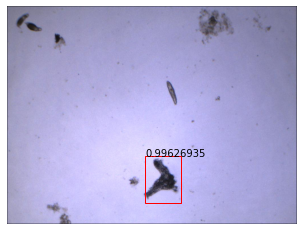

The number of amoeba is  1
34


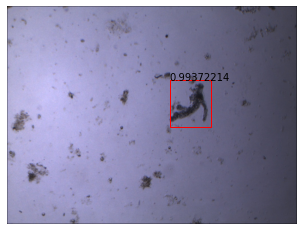

The number of amoeba is  1
35


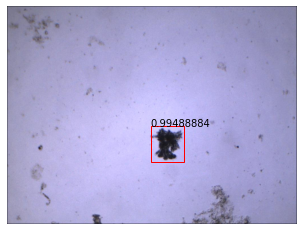

The number of amoeba is  1
36


In [ ]:
# create folder to save inference images
from PIL import Image
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

# find the path of original inference images
images_dir = "amoeba-detection/dataset-level2/amoebaDataset/testDataset/images"
save_root = "testDataset-pred/"
# run the inference and count the amoeba
t=0
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  save_file = save_root + img
  save_predicted(image, model, cfg, save_file)
  t=t + count1_amoeba(image,model,cfg)
  print(t)

In [ ]:
# save the inference folder to local

# !zip -r testDataset-pred.zip testDataset-pred
# from google.colab import files
# files.download("testDataset-pred.zip")

## Prediction time

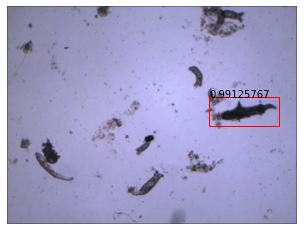

prediction time is 0.6780221462249756s


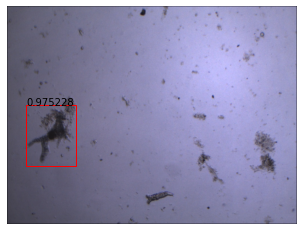

prediction time is 0.673372745513916s


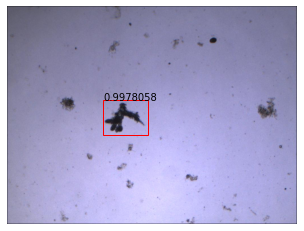

prediction time is 0.6438615322113037s


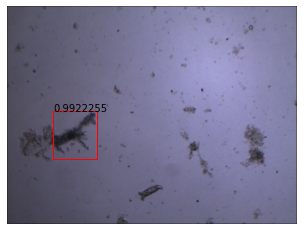

prediction time is 0.6484496593475342s


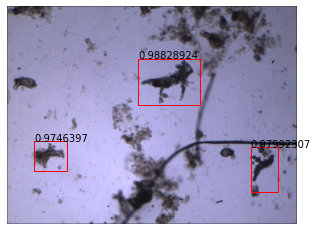

prediction time is 0.6630842685699463s


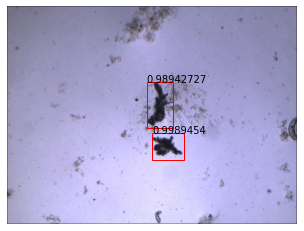

prediction time is 0.6492817401885986s


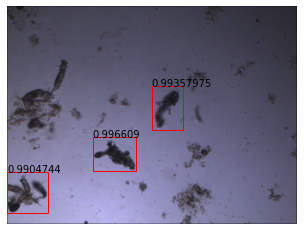

prediction time is 0.6643099784851074s


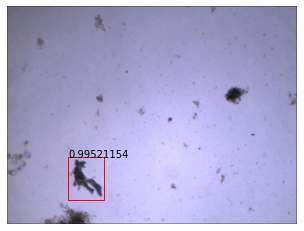

prediction time is 0.6366164684295654s


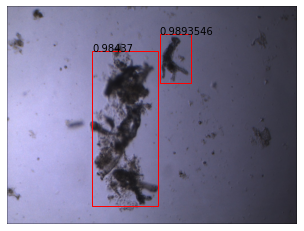

prediction time is 0.6534140110015869s


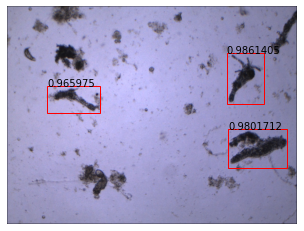

prediction time is 0.6719036102294922s


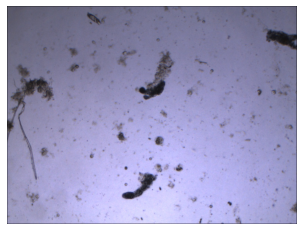

prediction time is 0.6736421585083008s


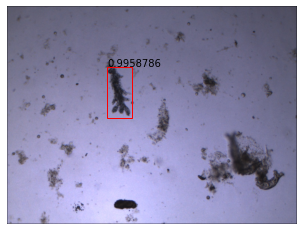

prediction time is 0.6637349128723145s


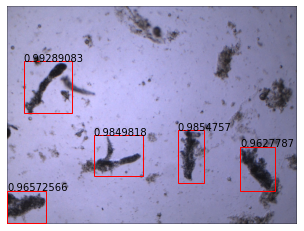

prediction time is 0.6862914562225342s


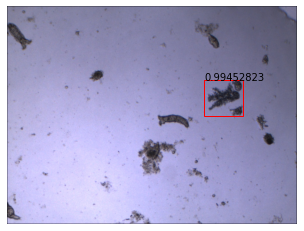

prediction time is 0.6647567749023438s


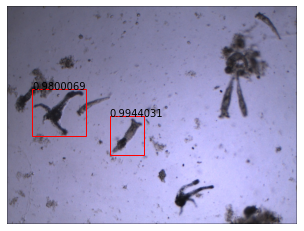

prediction time is 0.6775245666503906s


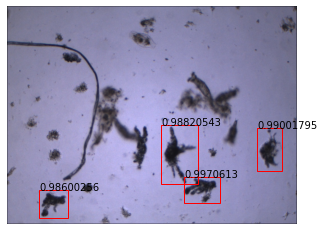

prediction time is 0.6808922290802002s


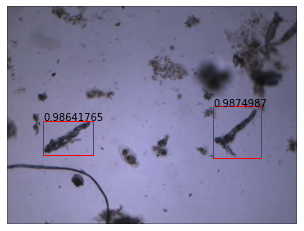

prediction time is 0.6517832279205322s


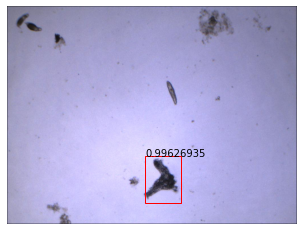

prediction time is 0.6467931270599365s


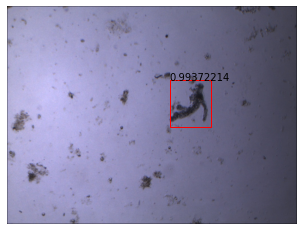

prediction time is 0.6460280418395996s


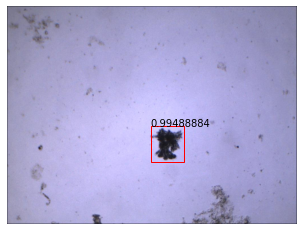

prediction time is 0.6482958793640137s


In [ ]:
# estimate the prediction time

from PIL import Image
import time
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

# find the path of original inference images
images_dir = "amoeba-detection/dataset-level2/amoebaDataset/testDataset/images"
save_root = "testDataset-pred/"
# run the inference and count the amoeba

for img in listdir(images_dir):
  start = time.time()
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  save_file = save_root + img
  save_predicted(image, model, cfg, save_file)
  end = time.time()
  predTime = end - start
  print("prediction time is " + str(predTime) + "s")